In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np
from scipy.special import factorial
from scipy.optimize import minimize
from scipy.linalg import svd, block_diag
from scipy.interpolate import interp1d
import scipy.stats
from tqdm import tqdm
import starry
print(starry.__version__)
import earthshine
import tensorflow as tf
import os
import glob
from PIL import Image
from scipy import ndimage
from IPython.display import HTML

1.0.0.dev0


In [4]:
# Load the coastlines
import matplotlib.image as mpimg
coastlines = mpimg.imread("../data/coastlines.png")
csum = np.sum(coastlines, axis=-1)
coastlines[csum < 4] = [0, 0, 0, 1]
coastlines[csum == 4] = [1, 1, 1, 0]

75


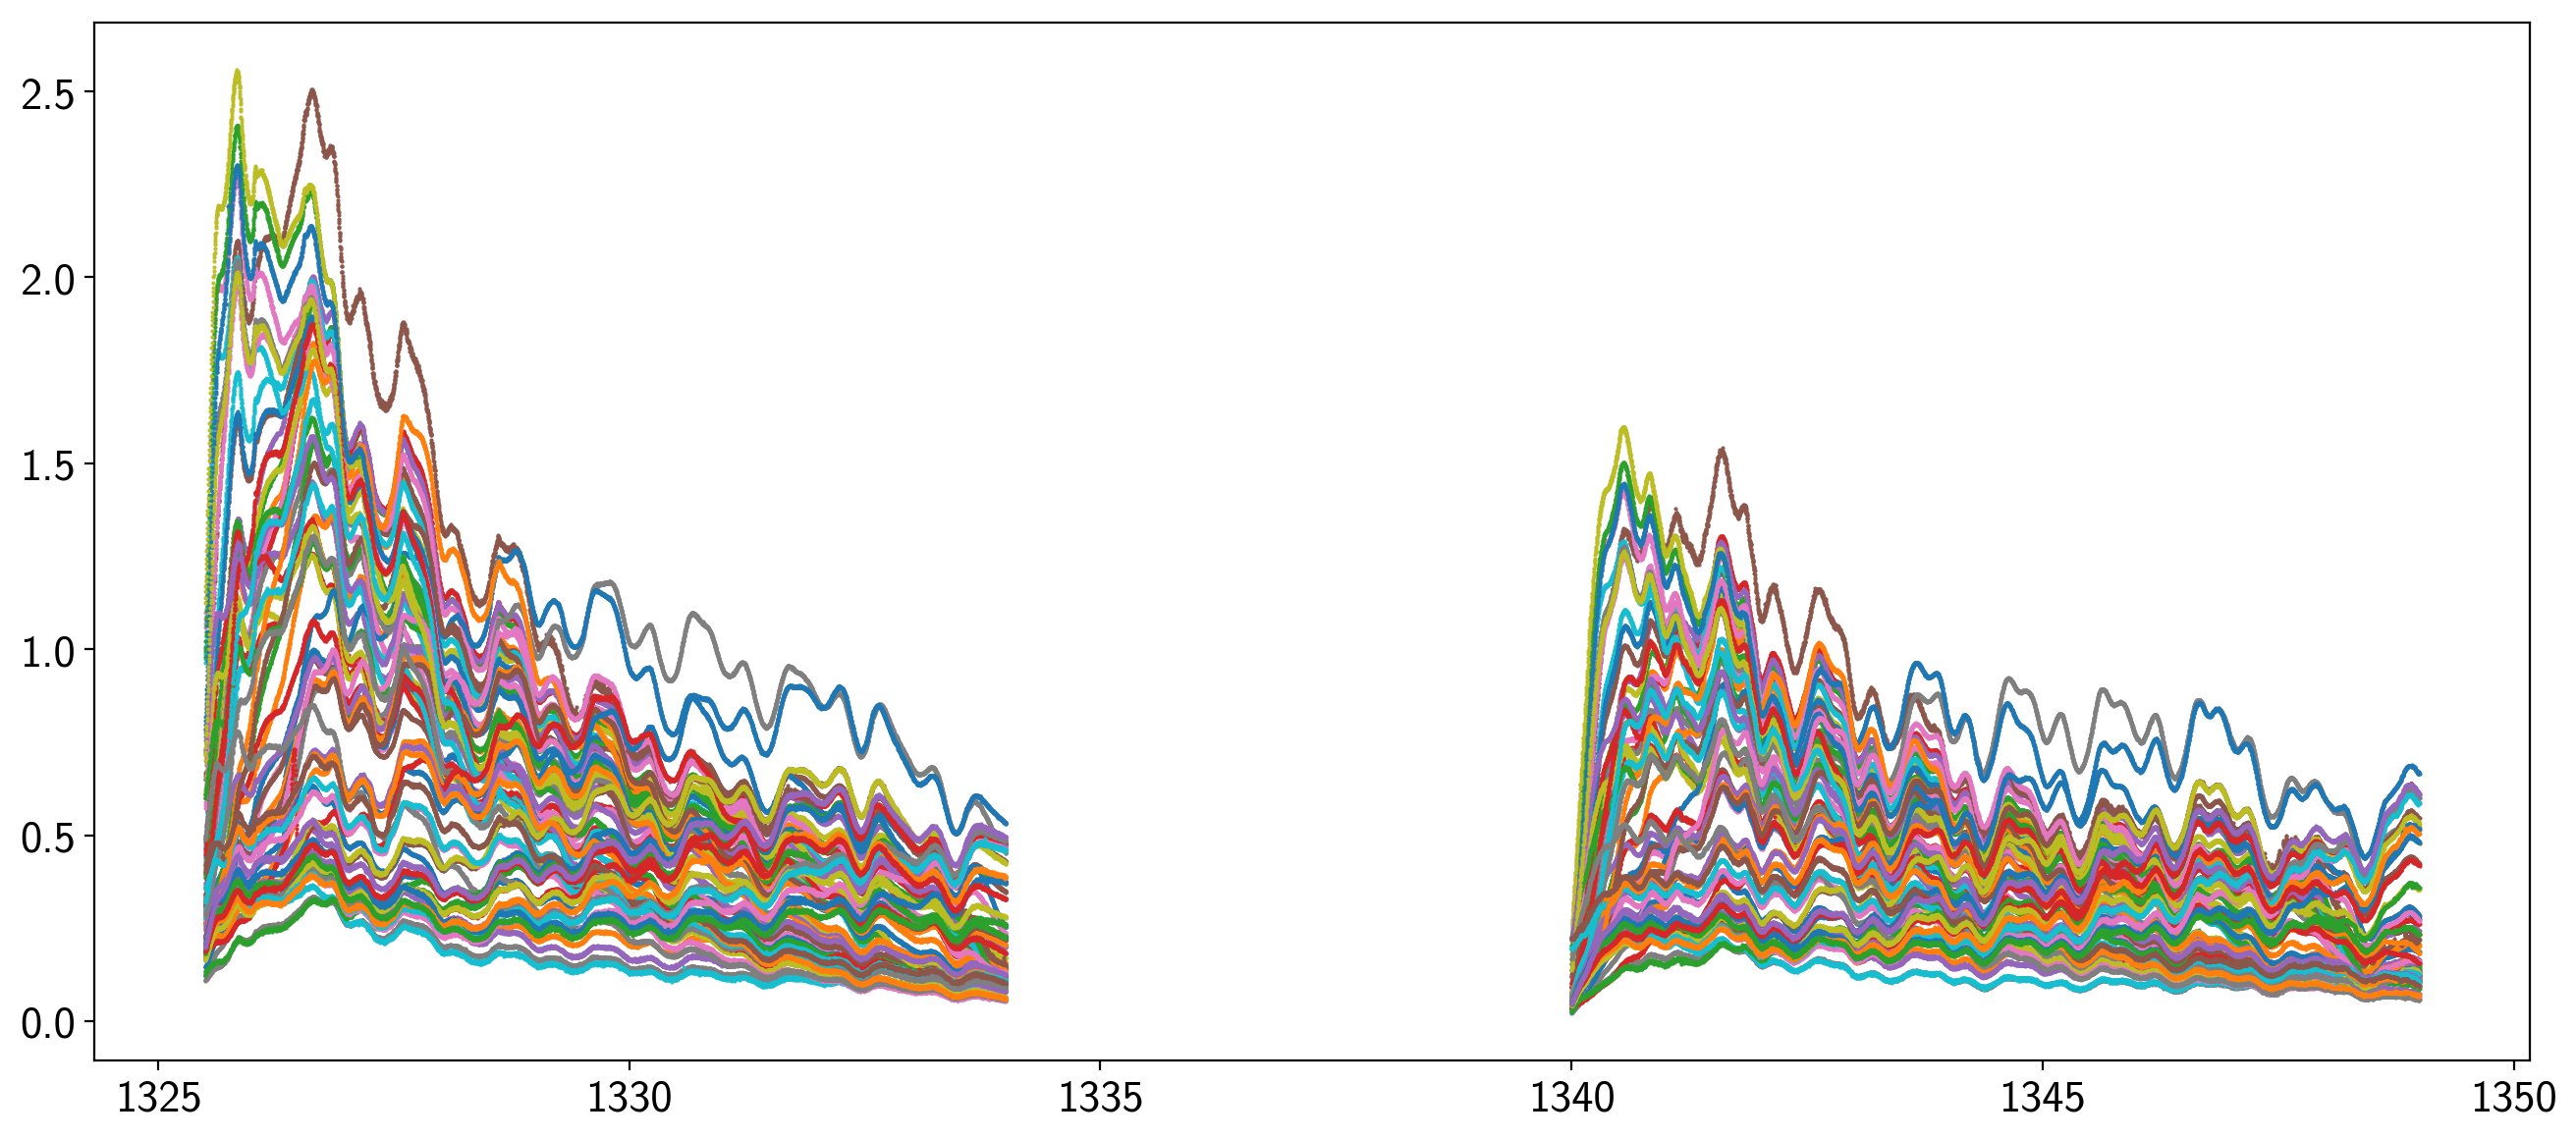

In [5]:
# Load the data for sector 1
data1 = np.load("../data/sector01-data.npz")
time1 = data1["time"]
flux1 = data1["flux"]
flux_err1 = data1["flux_err"]
bkg1 = data1["bkg"]
print(len(flux1))

# Remove the background so we can do PLD
for i in range(len(flux1)):
    flux1[i] -= bkg1[i]

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in flux1:
    line, = ax.plot(time1, f, '.', ms=1)

In [6]:
# Compute the polynomial basis for sector 1
nB1poly = 5
t11 = time1[time1 < 1337.5]
t12 = time1[time1 > 1337.5]
tt = 2 * ((t11 - t11[0]) / (t11[-1] - t11[0]) - 0.5)
B1 = np.vander(tt, N=nB1poly, increasing=True)
U, _, _ = svd(B1)
B11 = U[:, :nB1poly - 1]
B11 = np.hstack((np.ones((len(tt), 1)), B11))
tt = 2 * ((t12 - t12[0]) / (t12[-1] - t12[0]) - 0.5)
B1 = np.vander(tt, N=nB1poly, increasing=True)
U, _, _ = svd(B1)
B12 = U[:, :nB1poly - 1]
B12 = np.hstack((np.ones((len(tt), 1)), B12))
B1 = block_diag(B11, B12)

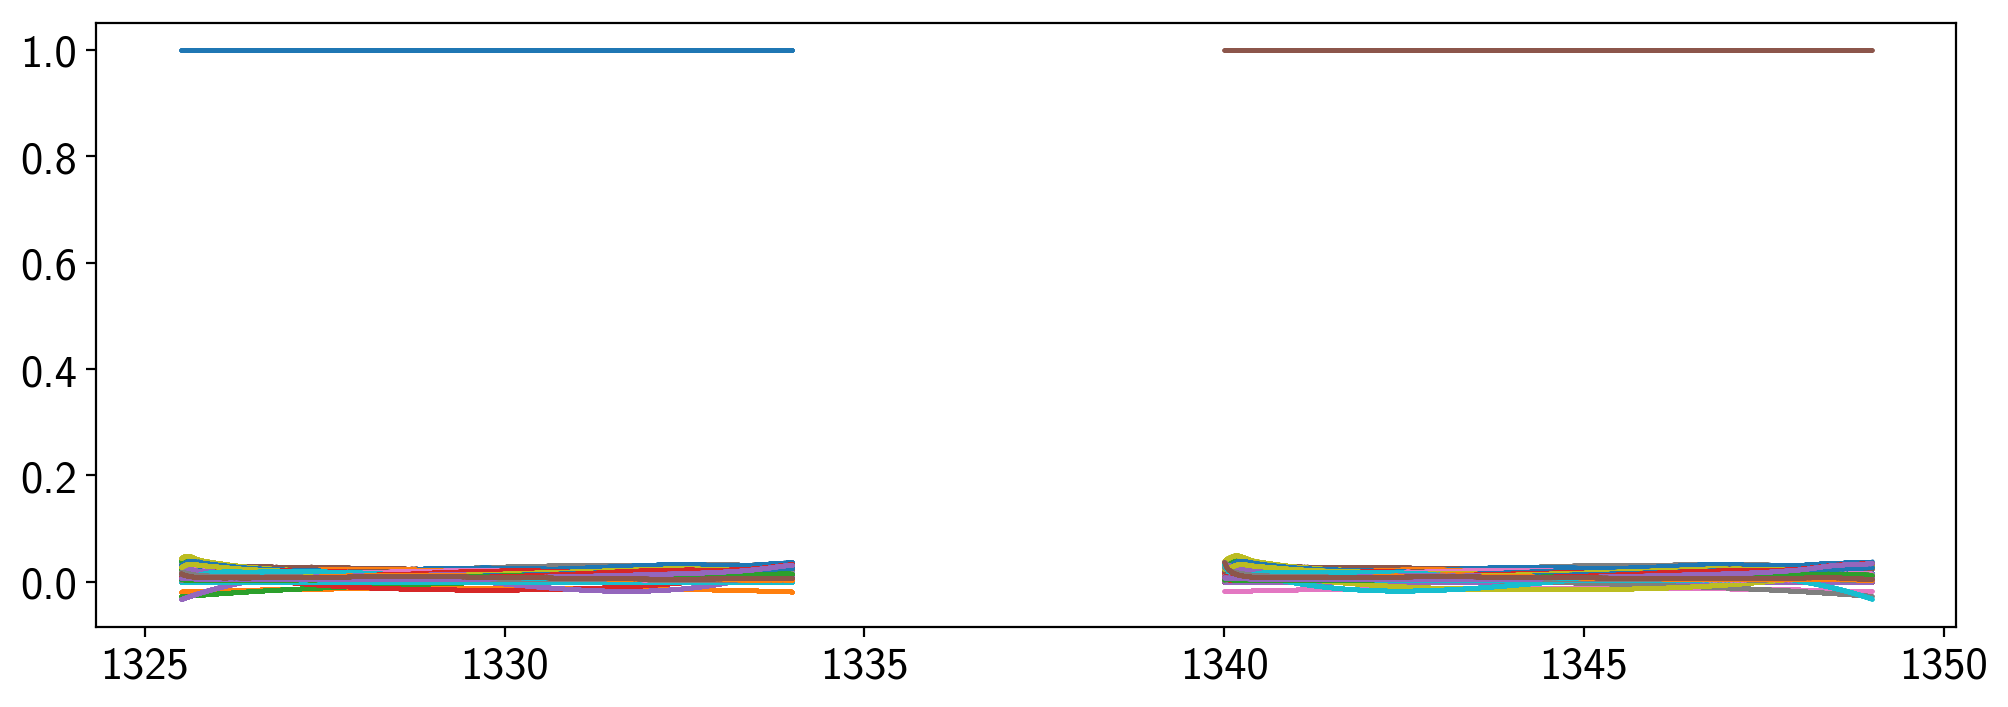

In [7]:
# Compute the PLD basis for sector 1
flux_sum1 = np.sum(flux1, axis=0)
B1 = np.hstack((B1, np.hstack([(flux1[n] / flux_sum1).reshape(-1, 1) for n in range(len(flux1))])))
for n in range(len(flux1) + 1):
    plt.plot(time1, B1[:, n], '.', ms=1)

In [8]:
B1.shape

(11363, 85)

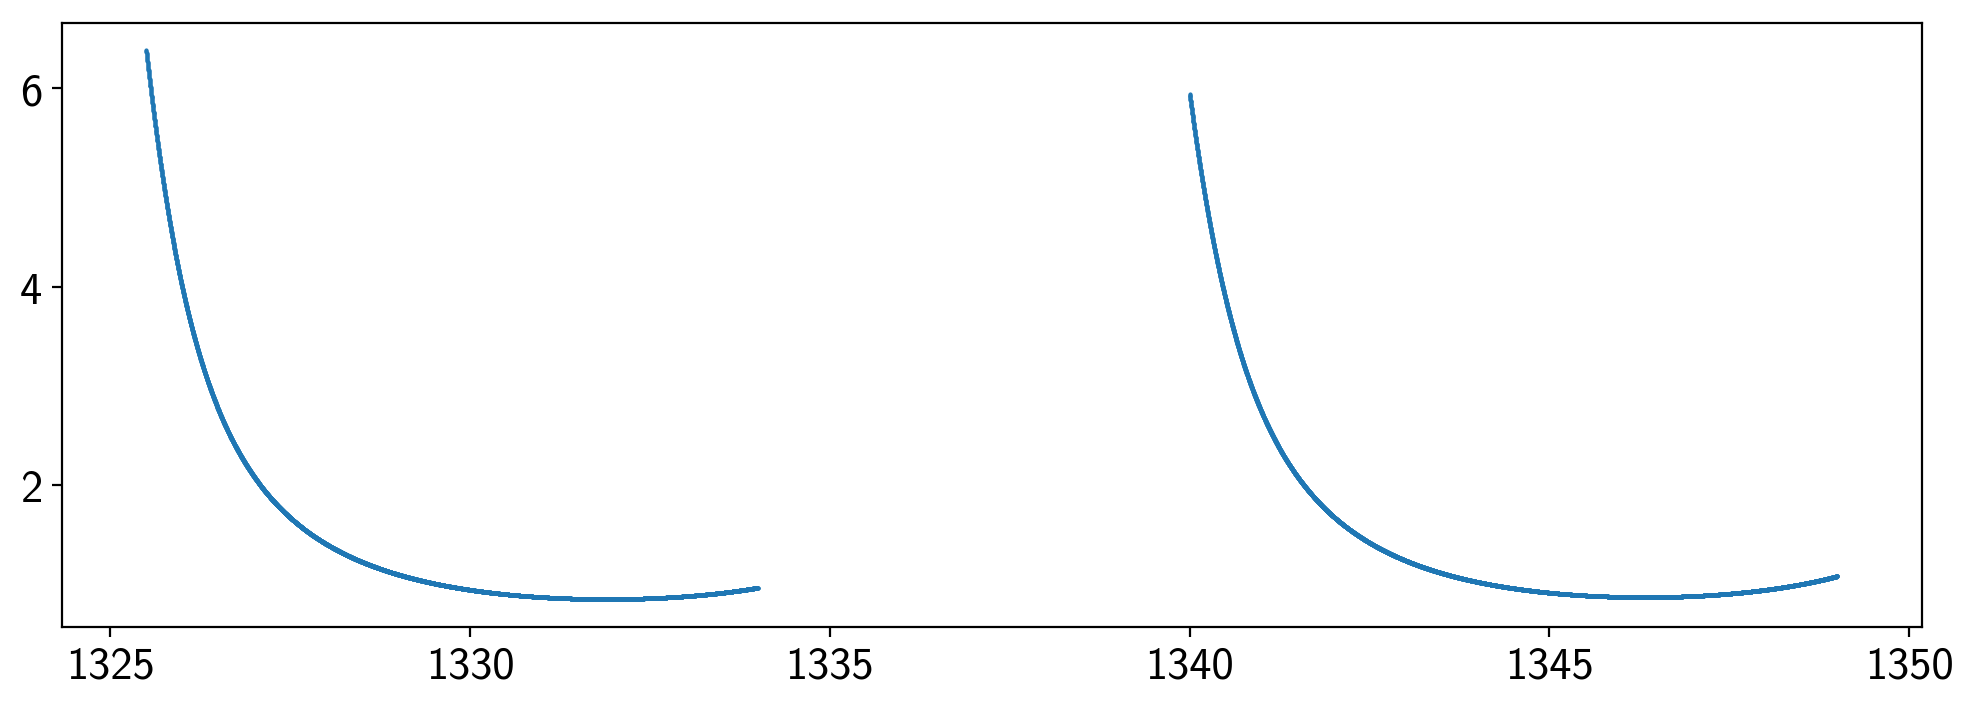

In [9]:
# Compute the TESS-Earth distance as a function of time for S1
tvec1 = earthshine.tess_earth_vector(time1)
tr1 = np.sqrt(tvec1[0] ** 2 + tvec1[1] ** 2 + tvec1[2] ** 2)

# This is the amplitude of the Earthshine (not a fit parameter)
amp1 = (1 / tr1 ** 2).reshape(-1, 1)
amp1 /= np.nanmedian(amp1)
amp1 = amp1.reshape(-1)
plt.plot(time1, amp1, '.', ms=1);

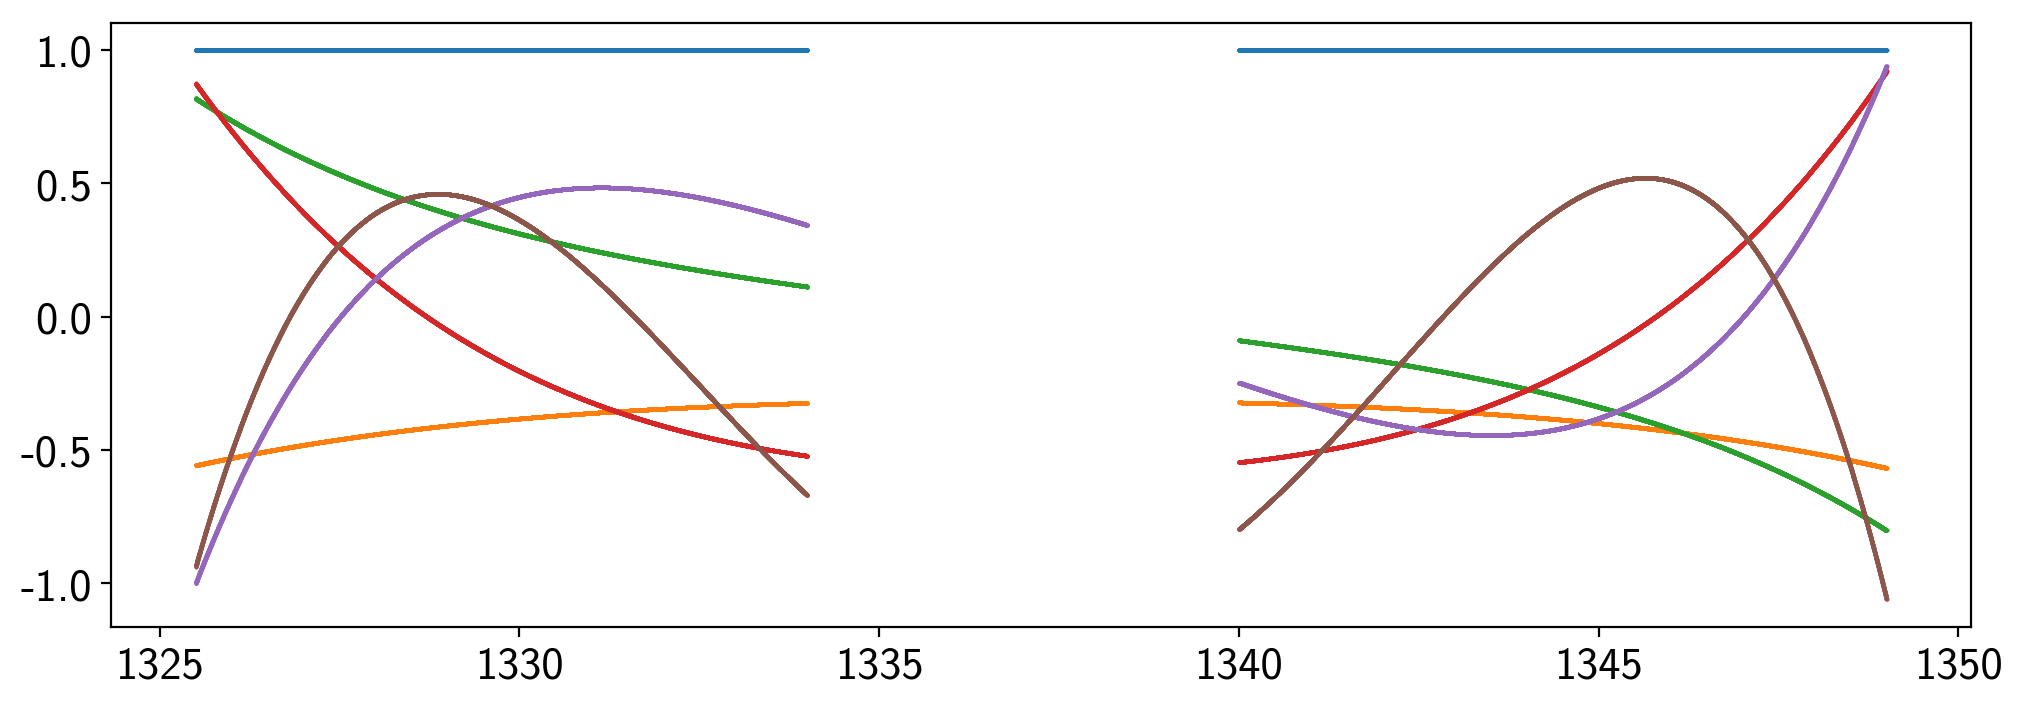

In [10]:
# Construct an orthogonal temporal basis
nt = 6
t = 2 * ((time1 - time1[0]) / (time1[-1] - time1[0]) - 0.5)
C = np.vander(t, N=nt, increasing=True)
U, _, _ = svd(C)
C = np.hstack((np.ones((len(t), 1)), U[:, :nt - 1]))
if nt > 1:
    C[:, 1:] /= (0.5 * (np.max(C[:, 1:]) - np.min(C[:, 1:])))
C1 = C[:len(time1)]
C2 = C[len(time1):]
plt.plot(time1, C1, '.', ms=1);

100%|██████████| 11363/11363 [00:05<00:00, 1975.07it/s]


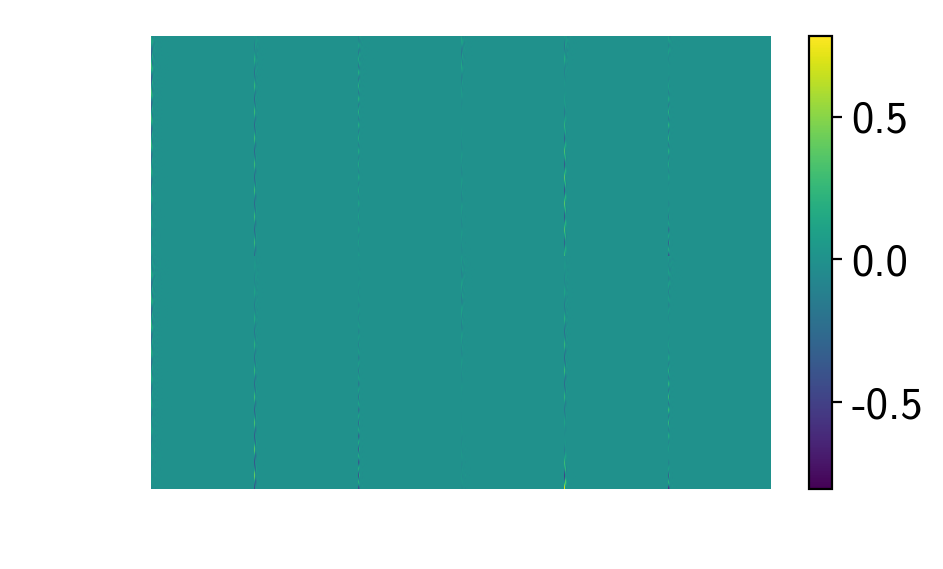

In [11]:
# The starry model for S1
ydeg = 25
phase0 = -56.5
# JD 2458325.5 = ERA 303.5 (https://dc.zah.uni-heidelberg.de/apfs/times/q/form)
ny = (ydeg + 1) ** 2 - 1

# Get the design matrix
X1, X01 = earthshine.design_matrix(time1, ydeg=ydeg, nt=1, phase0=phase0, fit_linear_term=False)
X1_static = np.array(X1)
X1 = np.hstack(([X1 * C1[:, k].reshape(-1, 1) for k in range(nt)]))

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X1, aspect="auto")
plt.colorbar(im)
ax.axis('off');

In [12]:
# The pixelization matrix
npix = 5000
res = int(np.sqrt(npix))
ntsamp = nt
omega = np.linspace(0, 2 * np.pi, res)
z = np.linspace(0.01, 1 - 0.01, res)
omega, z = np.meshgrid(omega, z)
omega = omega.flatten()
z = z.flatten()
npix = len(z) * 2
x = np.sqrt(1 - z ** 2) * np.cos(omega)
y = np.sqrt(1 - z ** 2) * np.sin(omega)
map_ = starry.Map(ydeg)
P = np.array([np.array(map_.linear_intensity_model(theta=theta, x=x, y=y)) for theta in [0., 180.]])
P0 = P[:, :, 0].reshape(-1)
P = P[:, :, 1:].reshape(-1, ny)

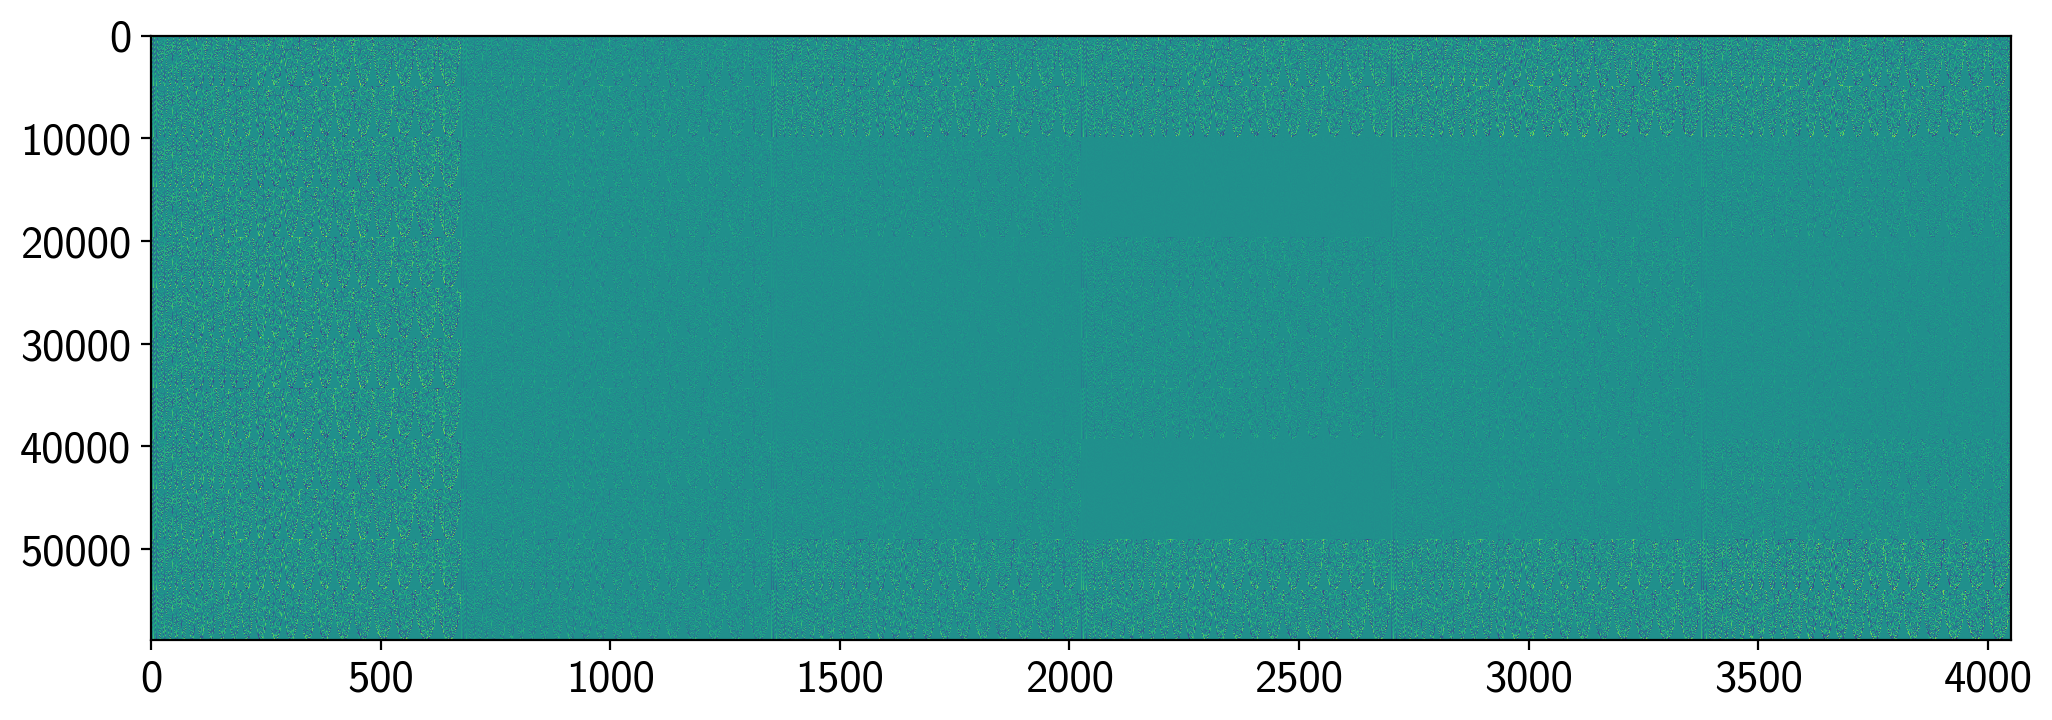

In [13]:
# Time samples
tsamp = np.linspace(0, len(time1) - 1, ntsamp, dtype=int)
P = np.vstack([np.hstack([P * C[j, k] for k in range(nt)]) for j in tsamp])
P0 = np.concatenate([P0 for j in tsamp])
plt.imshow(P, aspect="auto");

In [14]:
# Define the priors
def amp_l(l, a=2.0, b=1.5, c=0.035):
    """The power spectrum prior."""
    if l == 0:
        return 1.0
    elif l < a:
        return c * l ** b
    else:
        return c * a ** (2 * b) * l ** -b

def amp_t(t):
    """The prior on the temporal components."""
    if t == 0:
        return 1
    else:
        return 0.1 * np.exp(-(t - 1))    
    
# The L2 prior on the Ylms
LX = np.ones(ny * nt)
i = 0
for n in range(nt):
    for l in range(1, ydeg + 1):
        for m in range(-l, l + 1):
            LX[i] = amp_l(l) ** 2 * amp_t(n) ** 2
            i += 1
power_spectrum = np.array([amp_l(l) for l in range(1, ydeg + 1)])

# Downweight the prior by this amount
# when computing the linear solution
linLXfac = (0.0005) ** 2
            
# Define the L2 prior on the multiplicative model
LB1 = (0.1) ** 2
LB2 = (0.1) ** 2

# The (inverse) penalty factor for intensity outside of [0, 1]
LP = (1e-4) ** 2

In [15]:
# Initialize the models for S1
nc1 = len(time1)
nl1 = len(flux1)

Xwx1 = np.ones(nc1)
Bwb1 = np.array([np.ones(nc1) * amp1 for i in range(nl1)]).reshape(-1)

# The diagonal of the data covariance
D1 = flux_err1.reshape(-1) ** 2

# The flattened light curves
data1 = flux1.reshape(-1)

In [16]:
# The augmented starry design matrix & dataset
XBig = np.tile(X1, (nl1, 1))
X0Big = np.tile(X01, (nl1, 1)).reshape(-1)

# Versions with no temporal components:
XBig_static = np.tile(X1_static, (nl1, 1))

# All data
D = np.array(D1)
data = np.array(data1)

In [17]:
# Solve the bilinear problem iteratively. Here our loss function is *just* the L2
# norm, so we downweight the power spectrum prior on the coefficients to keep
# the map positive and well-behaved. This will serve as an initial guess for the
# TensorFlow optimization below.
# We also do NOT solve for time variability at this point.
compute = True

if compute or not os.path.exists("../data/bilinear_S1_temporal.npz"):
    niter = 50
    loss = np.zeros(niter)
    like = np.zeros(niter)
    wb1 = np.zeros((nl1, B1.shape[1]))
    for n in tqdm(range(niter)):
        # Compute the baseline model for S1: one per light curve
        for i in range(nl1):
            l = slice(i * nc1, (i + 1) * nc1, 1)
            wb1[i] = starry.MAP(B1, LB1, D1[l] / (Xwx1 * amp1) ** 2, data1[l] / (Xwx1 * amp1))
            Bwb1[l] = np.dot(B1, wb1[i]) * amp1

        # Compute the starry model: shared by all light curves
        # **Time variability turned OFF**
        Bwb = np.array(Bwb1)
        wx = starry.MAP(XBig_static, linLXfac * LX[:ny], D / Bwb ** 2, data / Bwb - X0Big)
        wx = np.append(wx, np.zeros(ny * (nt - 1)))
        Xwx1 = np.dot(X1, wx) + X01

        # Render the image (for the loss calculation)
        img = np.dot(P, wx) + P0

        # Compute the loss: chi squared
        model1 = Bwb1 * np.tile(Xwx1, nl1)
        model = model1
        like[n] = 0.5 * np.sum(((data - model) ** 2 / D))
        loss[n] = like[n] + 0.5 * (
            np.sum([wb1[i] ** 2 / LB1 for i in range(nl1)]) +
            np.sum(wx ** 2 / LX) +
            np.sum(img[img < 0] ** 2 / LP) + 
            np.sum((img[img > 1] - 1) ** 2 / LP)
        )
    np.savez("../data/bilinear_S1_temporal.npz", wb1=wb1, wx=wx, loss=loss, like=like)
else:
    bdata = np.load("../data/bilinear_S1_temporal.npz")
    wb1 = bdata["wb1"]
    wx = bdata["wx"]
    loss = bdata["loss"]
    like = bdata["like"]

100%|██████████| 50/50 [12:43<00:00, 19.36s/it]


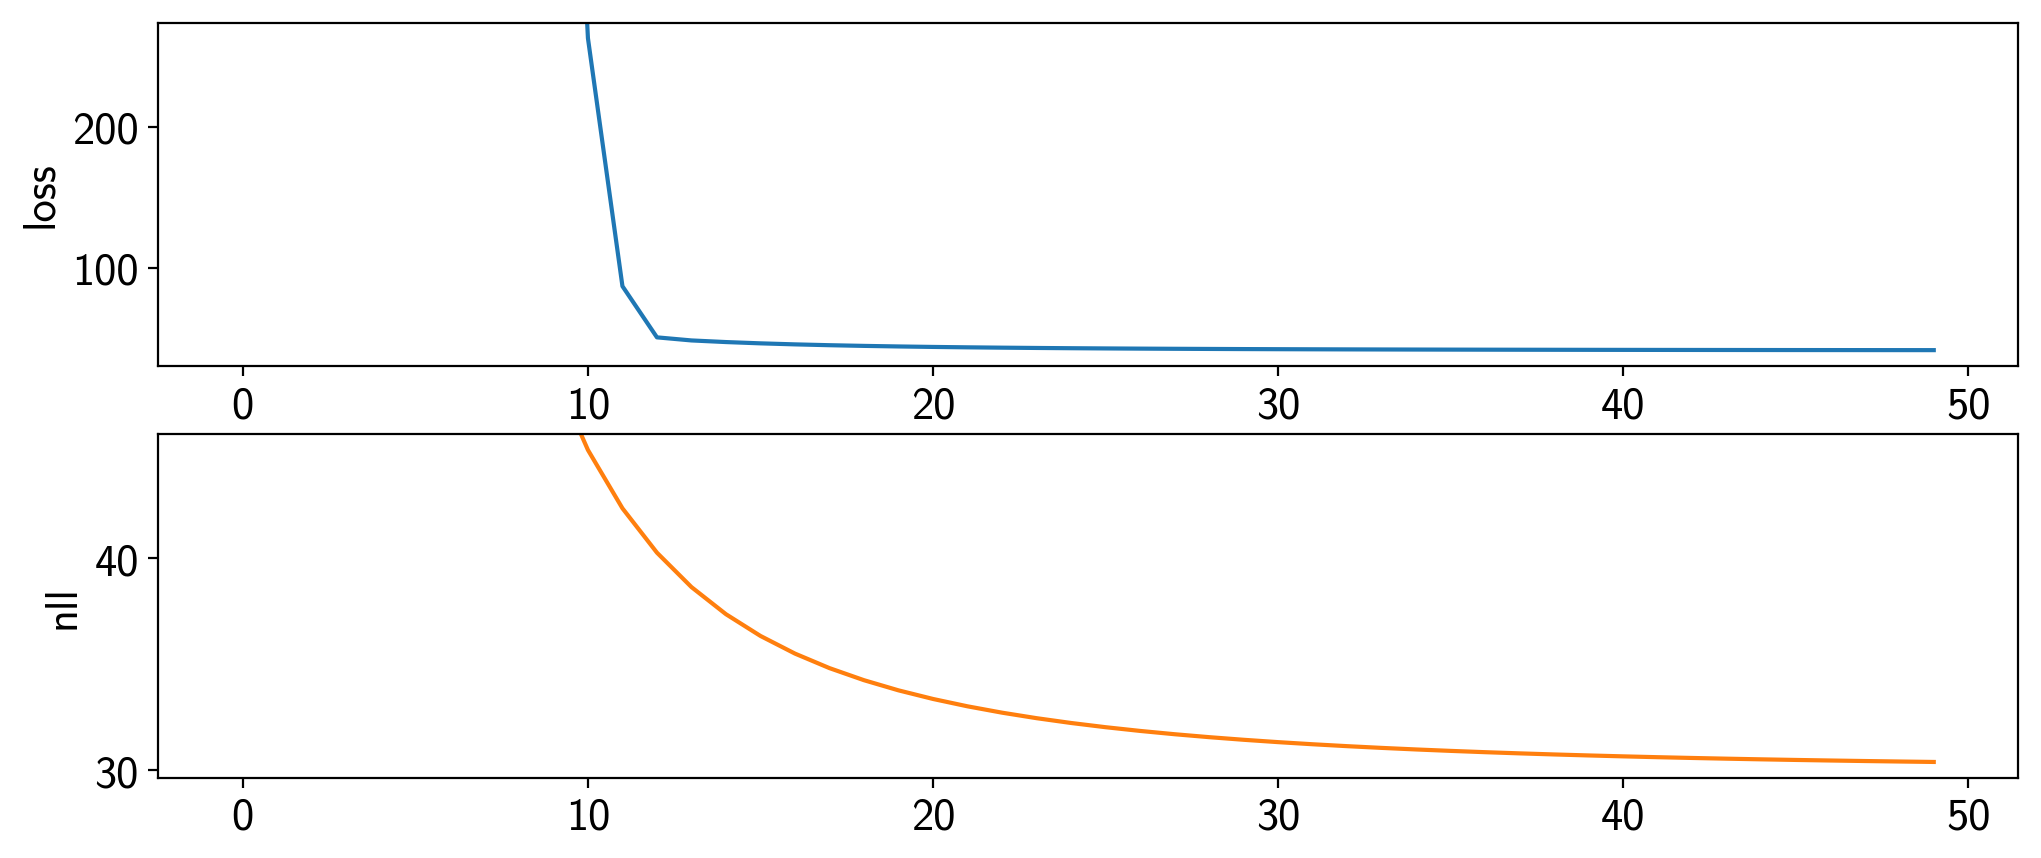

In [18]:
# Plot the loss and the negative log likelihood
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 10
ax[0].plot(loss[burn:] / (nc1 * nl1), alpha=0)
ax[1].plot(like[burn:] / (nc1 * nl1), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc1 * nl1), color="C0");
ax[1].plot(like / (nc1 * nl1), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

In [ ]:
# Declare the TensorFlow model
session = tf.Session()
T = tf.float64

# The data
tdata1 = tf.constant(data1.reshape(-1, 1), dtype=T)
tcov1 = tf.constant(D1.reshape(-1, 1), dtype=T)
tamp1 = tf.constant(np.tile(amp1, nl1).reshape(-1, 1), dtype=T)

# The constant matrices
tB1 = tf.constant(B1, dtype=T)
tX1 = tf.constant(X1, dtype=T)
tX01 = tf.constant(X01.reshape(-1, 1), dtype=T)
tP = tf.constant(P, dtype=T)
tP0 = tf.constant(P0.reshape(-1, 1), dtype=T)

# The priors
tLX = tf.constant(LX, dtype=T)
tLB1 = tf.constant(LB1, dtype=T)
tLP = tf.constant(LP, dtype=T)
tLogPowerVar = tf.constant(0.3 ** 2, dtype=T)
tgammamean = tf.constant(1.5, dtype=T)
tgammavar = tf.constant(0.1 ** 2, dtype=T)
tMaxTemporalPower = tf.constant(8e-4, dtype=T)
tTemporalPowerPenalty = tf.constant(1e-5 ** 2, dtype=T)

# The things we're solving for
twb1 = tf.Variable(wb1.T, dtype=T)
twx = tf.Variable(wx.reshape(-1, 1), dtype=T)
tgamma = tf.Variable(1.5, dtype=T)

# This is our actual model
tBwb1 = tf.reshape(tf.transpose(tf.matmul(tB1, twb1)), [-1, 1]) * tamp1
tXwx1 = tf.matmul(tX1, twx) + tX01
tmodel1 = tBwb1 * tf.tile(tXwx1, [nl1, 1])

# The chi^2 part of the loss function
tloss_like1 = 0.5 * tf.reduce_sum(tf.squared_difference(tdata1, tmodel1) / tcov1)
tloss_like = tloss_like1

# The prior on the baseline model
tloss_mult1 = 0.5 * tf.reduce_sum(tf.square(twb1) / tLB1)
tloss_mult = tloss_mult1

# Regularize the k > 0 time components
ttotal_power = tf.square(twx[ny:])
ttotal_power_bad = tf.where(ttotal_power > tMaxTemporalPower, ttotal_power, tf.zeros_like(ttotal_power))
tloss_time = 0.5 * tf.reduce_sum(tf.square(ttotal_power_bad) / (tTemporalPowerPenalty))

# Enforce the power spectrum
twx_of_t = tf.convert_to_tensor([tf.reduce_sum([twx[k * ny:(k + 1) * ny] * C[j, k] 
                                                for k in range(nt)], axis=0) for j in tsamp], dtype=T)
tpower = tf.squeeze(tf.convert_to_tensor(
    [tf.reduce_sum([tf.square(twx_of_t[:, l ** 2 + l + m - 1]) 
                    for m in range(-l, l + 1)], axis=0) 
     for l in range(1, ydeg + 1)]
    , dtype=T))
tLogPowerMean = tf.reshape(tf.log(tf.pow(tf.convert_to_tensor(np.arange(1, ydeg + 1), dtype=T), -tgamma)), (-1, 1))
tloss_spec = 0.5 * tf.reduce_sum(tf.squared_difference(tf.log(tpower), tLogPowerMean) / tLogPowerVar)
tloss_gamma = 0.5 * tf.squared_difference(tgamma, tgammamean) / tgammavar

# Render the map on a coarse theta-phi-time grid and 
# compute the penalty on intensities outside of [0, 1]
timg = tf.matmul(tP, twx) + tP0
tloss_neg = 0.5 * tf.reduce_sum(tf.square(tf.where(timg < 0, timg, tf.zeros_like(timg))) / tLP)
tloss_pos = 0.5 * tf.reduce_sum(tf.square(tf.where(timg > 1, timg - 1, tf.zeros_like(timg))) / tLP)

# The total loss function
tloss = tloss_like + tloss_mult + tloss_spec + tloss_gamma + tloss_neg + tloss_pos + tloss_time

# Set up the optimizer
var_list = [twb1, twx, tgamma]
opt = tf.train.AdamOptimizer().minimize(tloss, var_list=var_list)
session.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# Iterate: we are now solving the full problem, with the full loss function
# specified by all our crazy constraints
tniter = 1000
like = np.zeros(tniter)
loss = np.zeros(tniter)
with tqdm(total=tniter, postfix=[0, 0]) as tq:
    for i in range(tniter):
        session.run(opt)
        like[i] = session.run(tloss_like)
        loss[i] = session.run(tloss)
        tq.postfix[0] = int(loss[i] / (nc1 * nl1))
        tq.postfix[1] = int(like[i] / (nc1 * nl1))
        tq.update()

 30%|██▉       | 295/1000 [09:56<04:01,  2.92it/s[20, 9]]    

In [ ]:
# Get the values of a bunch of the TF variables
wb1 = session.run(tf.squeeze(twb1)).T
wx = session.run(tf.squeeze(twx))
Bwb1 = session.run(tf.squeeze(tBwb1))
Xwx1 = session.run(tf.squeeze(tXwx1))
model1 = session.run(tf.squeeze(tmodel1))
power = session.run(tpower)
img = session.run(tf.squeeze(timg))

In [ ]:
gamma = session.run(tgamma)
print(gamma)

In [ ]:
# Plot the distribution of intensities throughout the timeseries
fig, ax = plt.subplots(ntsamp // 2 + 1, 2, figsize=(10, 5))
ax = ax.flatten()
for n in range(ntsamp):
    ax[n].hist(img[n*npix:(n+1)*npix], bins=500, density=True);
    ax[n].set_xlim(-0.5, 1.5)
    ax[n].axvspan(0, 1, color="C0", alpha=0.1)
for axis in ax:
    axis.axis('off');

In [ ]:
# Plot the flattened image as a function of time
img = np.dot(P, wx) + P0
plt.plot(img.flatten(), 'C0.', ms=3, alpha=0.5);

In [ ]:
# Plot the loss and likelihood functions
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 0
ax[0].plot(loss[burn:] / (nc1 * nl1), alpha=0)
ax[1].plot(like[burn:] / (nc1 * nl1), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc1 * nl1), color="C0");
ax[1].plot(like / (nc1 * nl1), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

In [ ]:
# Set the map coefficients
map = starry.Map(ydeg=ydeg, nt=nt, reflected=True)
map[0, 0, 0] = 1
for n in range(nt):
    map[1:, :, n] = wx[n * ny:(n + 1) * ny]

# Plot the coefficients and the map at t = 0
fig = plt.figure(figsize=(12, 3))
ax = [plt.subplot2grid((3, 5), (0, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (1, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (2, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (0, 2), rowspan=3, colspan=3)]
for i, axis in enumerate(ax):
    for tick in axis.xaxis.get_major_ticks() + axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    if i < 3:
        axis.set_xticks([])
        axis.margins(0.1, 0.1)
ax[0].plot(np.log10(np.abs(wx)), '-')
ax[0].plot(np.log10(np.sqrt(LX)), '-')
ax[0].set_ylabel(r"$w_X$", fontsize=10)
ax[1].plot(np.log10(power), 'C0.', ms=2)
ax[1].plot(np.log10(np.arange(1, ydeg + 1) ** -gamma), 'C1-')
ax[1].set_ylabel(r"$P(t)$", fontsize=10)
for i in range(nl1):
    ax[2].plot(np.log10(np.abs(wb1[i])), 'C0.', ms=2)
ax[2].axhline(np.log10(np.sqrt(LB1)), color='C0')
ax[2].axhline(np.log10(np.sqrt(LB2)), color='C2')
ax[2].set_ylabel(r"$w_B$", fontsize=10)
cmap = plt.get_cmap("Blues_r")
cmap.set_under('w')  
map_ = starry.Map(ydeg)
map_[:, :] = map[:, :, 0]
res = 300
Z = map_.render(res=res, projection="rect", cmap=cmap)[0]
im = ax[3].imshow(Z, origin="lower", cmap=cmap, extent=(-180, 180, -90, 90));
fig.colorbar(im)
ax[3].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.25)

# Plot the data and model
thin = 10
nsamp = 5
fig = plt.figure(figsize=(11, 7))
ax = [plt.subplot2grid((5, 1), (0, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (2, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)]
tthin = time1[::thin]
inds = np.arange(nl1, dtype=int)
np.random.shuffle(inds)
inds = inds[:nsamp]
for i in inds:
    # Indices for this light curve
    l = slice(i * nc1, (i + 1) * nc1, 1)
    ax[0].plot(tthin, data1[l][::thin], 'k.', alpha=0.75, ms=2)
    ax[0].plot(tthin, data1[l][::thin], 'k-', alpha=0.25, lw=1)
    ax[0].plot(tthin, model1[l][::thin], color="C0", label="model" if i == inds[0] else None);
    ax[0].plot(tthin, Xwx1[::thin], color="C1", alpha=0.25, label="X" if i == inds[0] else None);
    ax[0].plot(tthin, Bwb1[l][::thin], color="C2", alpha=0.25, label="B" if i == inds[0] else None);
ax[1].plot(time1, np.nanmedian([data1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.75, ms=3)
ax[1].plot(time1, np.nanmedian([model1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'C0-', lw=2)
ax[2].plot(time1, np.nanmedian([((data1 - model1) / np.sqrt(D1))[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.5, ms=3)
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Median Flux")
ax[2].set_ylabel("Residuals", fontsize=8)
ax[0].legend(fontsize=8, loc="lower right")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

In [ ]:
# Compare to "ground truth"
plt.plot(time1, Xwx1)
plt.plot(time1, np.load("../data/Xwx_truth.npz")["Xwx"]);

In [ ]:
# Compute the visibility matrix
lon, lat, viz = earthshine.visibility(time1, res=50)
lat_s = sorted(set(lat))
viz_lat_s = np.array([np.median(viz[lat == l]) for l in lat_s])
lat = np.linspace(-90, 90, res)
viz = np.interp(lat, lat_s, viz_lat_s).reshape(-1, 1)
viz /= np.max(viz)
Zviz = np.tile(viz, (1, res))

In [ ]:
# Load the "ground truth" image
if not os.path.exists("viirs.npz"):
    # Load the VIIRS images
    files = glob.glob("../data/viirs/*.jpeg")
    images = []
    for file in files:
        img = Image.open(file)
        img = np.asarray(img.resize((500, 500))) / 255.
        csum = np.sum(img, axis=-1)
        img[csum == 0] = [np.nan, np.nan, np.nan]
        images.append(img)
    images = np.array(images)

    # Take the mean in the red band
    avg = np.nanmean(images, axis=0)
    avg[np.isnan(avg)] = 0
    red = avg[:, :, 0]
    red[red < 0.05] = 1

    # Blur it
    blurred = ndimage.gaussian_filter(red, sigma=10)
    blurred = (blurred - np.nanmin(blurred)) / (np.nanmax(blurred) - np.nanmin(blurred))

    # Transform to spherical harmonics limited to `l = ydeg`
    # and then back to a lat-lon image, so we're comparing
    # apples to apples. Use the beta version (0.3.0) of starry for this
    import starry_beta
    print(starry_beta.__version__)
    maptru_ = starry_beta.Map(ydeg)
    maptru_.load_image(blurred)
    maptru = starry.Map(ydeg)
    maptru[:, :] = maptru_.y
    Ztru = maptru.render(res=res, projection="rect", cmap=cmap)[0]
    np.savez("viirs.npz", Ztru=Ztru)
else:
    Ztru = np.load("viirs.npz")["Ztru"]

# Figures!

In [ ]:
# Plot the results
fig, ax = plt.subplots(2, figsize=(10, 9))
fig.subplots_adjust(hspace=0.3)

# Plot the weighted solution
img = (Z * Zviz) / np.nanmax(Z * Zviz)
cmap.set_under(cmap(0))
im = ax[0].imshow(img, cmap=cmap, extent=(-180, 180, -90, 90), origin="lower", vmin=0, vmax=1);
cb = fig.colorbar(im, ax=ax[0]);
cb.set_label(label='Weighted Albedo', fontsize=14)
ax[0].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.5);
ax[0].axhline(lat[np.argmax(viz > 0.5)], color="w", ls='--', alpha=0.5)
ax[0].axhline(lat[::-1][np.argmax(viz[::-1] > 0.5)], color="w", ls='--', alpha=0.5);
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_yticks([-90, -45, 0, 45, 90]);
ax[0].set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax[0].xaxis.get_major_ticks() + ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax[0].annotate("Low visibility", xy=(0.5, 0.14), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75)
ax[0].annotate("Low visibility", xy=(0.5, 0.9), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75);

# Plot the weighted true image
Ztru_ = Ztru # High contrast: 1.0 / (1.0 + np.exp(-10 * (Ztru - 0.5)))
img = (Ztru_ * Zviz) / np.nanmax(Ztru_ * Zviz)
im = ax[1].imshow(img, cmap=cmap, extent=(-180, 180, -90, 90), origin="lower", vmin=0, vmax=1);
cb = fig.colorbar(im, ax=ax[1]);
cb.set_label(label='Weighted Albedo', fontsize=14)
ax[1].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.5);
ax[1].axhline(lat[np.argmax(viz > 0.5)], color="w", ls='--', alpha=0.5)
ax[1].axhline(lat[::-1][np.argmax(viz[::-1] > 0.5)], color="w", ls='--', alpha=0.5);
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_yticks([-90, -45, 0, 45, 90]);
ax[1].set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax[1].xaxis.get_major_ticks() + ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax[1].annotate("Low visibility", xy=(0.5, 0.14), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75)
ax[1].annotate("Low visibility", xy=(0.5, 0.9), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75);

# Save
#fig.savefig("../tex/figures/map.pdf", bbox_inches="tight")

In [ ]:
# Plot the data and model
fig = plt.figure(figsize=(10, 4))
ax = [plt.subplot2grid((4, 1), (0, 0), rowspan=3, colspan=1),
      plt.subplot2grid((4, 1), (3, 0), rowspan=1, colspan=1)]
t1 = np.array(time1)
t1[np.argmax(t1 > 1335)] = np.nan
ax[0].plot(time1, np.nanmedian([data1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.75, ms=3, label="Median Flux", zorder=-1)
ax[0].plot(t1, np.nanmedian([model1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'C0-', lw=1, label="Median Model", zorder=-1)
ax[0].legend(fontsize=10, numpoints=5, loc="upper left")
ax[1].plot(time1, np.nanmedian([(data1 - model1)[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.25, ms=2, zorder=-1)
ax[0].set_ylabel("Normalized Flux", labelpad=11.0)
ax[1].set_ylabel("Residuals")
ax[1].set_ylim(-0.060428, 0.060428)
ax[0].set_xticklabels([])
ax[1].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

ax[0].set_yticks([0, 0.5, 1, 1.5])
ax[0].set_ylim(0, 1.5)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax[1].set_xlabel("Time [TJD]", labelpad=10);
ax[0].set_rasterization_zorder(0)
ax[1].set_rasterization_zorder(0)

ax[0].annotate("S1.1", xy=(0.15, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S1.2", xy=(0.35, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S2.1\n(not fit)", xy=(0.7, 0.415), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S2.2\n(not fit)", xy=(0.9, 0.415), xycoords="axes fraction", ha="center", fontsize=12, color="k");
for axis in ax:
    axis.set_xlim(1322.6996364412623, 1384.3173625424297)

# Save
fig.savefig("../tex/figures/model_temporal.pdf", bbox_inches="tight", dpi=300)

In [ ]:
# Plot the power spectrum of the residuals
resid1 = np.nanmedian([(data1 - model1)[slice(i * nc1, (i + 1) * nc1, 1)] for i in range(nl1)], axis=0)
print(np.std(resid1))
from astropy.stats import LombScargle
frequency, power = LombScargle(time1, resid1).autopower()
per = 1.0 / frequency
plt.plot(np.log10(per[:]), np.log10(power[:]));
plt.xlabel("Log period");
plt.axvline(0.0, color='k', alpha=0.25)
plt.ylabel("Log power");

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(t1, Xwx1, 'C0', zorder=-1)
ax.set_ylabel("Normalized Reflectance")
ax.set_xlabel("Time [TJD]", labelpad=10);
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax.set_rasterization_zorder(0)

# Save
fig.savefig("../tex/figures/starry_model_temporal.pdf", bbox_inches="tight", dpi=300)

In [ ]:
# Render the map over time
Zanim = []
nframes = 50
for j in tqdm(np.linspace(0, len(time1) - 1, nframes, dtype=int), total=nframes):
    map_[:, :] = np.sum([map[:, :, k] * C[j, k] for k in range(nt)], axis=0)
    Zanim.append(map_.render(res=res, projection="rect", cmap=cmap)[0])

In [ ]:
# Weight the images by the visibility
img = (Zanim * Zviz) / np.nanmax(Zanim * Zviz)

# Animate it
fig, ax = plt.subplots(1, figsize=(10, 4))
extent = (-180, 180, -90, 90)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_yticks([-90, -45, 0, 45, 90]);
ax.set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
im = ax.imshow(img[0], origin="lower", 
                extent=extent, cmap=cmap,
                interpolation="none",
                vmin=0, vmax=1, 
                animated=True)
cb = fig.colorbar(im, ax=ax);
cb.set_label(label='Weighted Albedo', fontsize=14)
ax.imshow(coastlines, extent=extent, alpha=0.5);
def updatefig(i):
    im.set_array(img[i])
    return img,
ani = FuncAnimation(fig, updatefig, interval=75,
                    blit=False, frames=len(img))
ani.save('map_temporal.mp4', writer='ffmpeg')
plt.close()
display(HTML(ani.to_jshtml()))

In [ ]:
# Let's try to identify the regions that are always bright or always dark
fig, ax = plt.subplots(1, figsize=(10, 4))
zz = np.nanmin(img, axis=0)
zz = 1.0 / (1.0 + np.exp(-10 * (zz - 0.5)))
ax.imshow(zz, origin="lower", extent=(-180, 180, -90, 90), cmap=cmap);
cb = fig.colorbar(im, ax=ax);
ax.imshow(coastlines, extent=extent, alpha=0.5);
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_yticks([-90, -45, 0, 45, 90]);
ax.set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

In [ ]:
# Plot the data and model
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.5)
ax = [plt.subplot2grid((12, 12), (0, 0), rowspan=9, colspan=6),
      plt.subplot2grid((12, 12), (9, 0), rowspan=3, colspan=6)]
axim = [plt.subplot2grid((12, 12), (0, 6), rowspan=4, colspan=3),
        plt.subplot2grid((12, 12), (0, 9), rowspan=4, colspan=3),
        plt.subplot2grid((12, 12), (4, 6), rowspan=4, colspan=3),
        plt.subplot2grid((12, 12), (4, 9), rowspan=4, colspan=3),
        plt.subplot2grid((12, 12), (8, 6), rowspan=4, colspan=3),
        plt.subplot2grid((12, 12), (8, 9), rowspan=4, colspan=3)]

for i, j in enumerate(np.linspace(0, nframes, 6, dtype=int)):
    axim[i].imshow(img[i], origin="lower", extent=(-180, 180, -90, 90), cmap=cmap);
    axim[i].imshow(coastlines, extent=extent, alpha=0.5);
    axim[i].axis('off')
    axim[i].annotate(i + 1, xy=(0.05, 0.1), xycoords="axes fraction", color='w', fontsize=10)
    
t1 = np.array(time1)
t1[np.argmax(t1 > 1335)] = np.nan
medflx = np.nanmedian([data1[slice(i * nc1, (i + 1) * nc1, 1)] for i in range(nl1)], axis=0)
ax[0].plot(time1, medflx, 'k.', alpha=0.75, ms=3, label="Median Flux", zorder=-1)
ax[0].plot(t1, np.nanmedian([model1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'C0-', lw=1, label="Median Model", zorder=-1)
ax[0].legend(fontsize=10, numpoints=5, loc="upper left")
ax[1].plot(time1, np.nanmedian([(data1 - model1)[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.25, ms=2, zorder=-1)
ax[0].set_ylabel("Normalized Flux", labelpad=11.0)
ax[1].set_ylabel("Residuals")
ax[1].set_ylim(-0.060428, 0.060428)
ax[0].set_xticklabels([])
ax[1].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

ax[0].set_yticks([0, 0.5, 1, 1.5])
ax[0].set_ylim(0, 1.5)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax[1].set_xlabel("Time [TJD]", labelpad=10);
ax[0].set_rasterization_zorder(0)
ax[1].set_rasterization_zorder(0)

for i, tt in enumerate(np.linspace(0, len(time1) - 1, 6, dtype=int)):
    ax[0].annotate(i + 1, xy=(time1[tt], medflx[tt]), xycoords="data", 
                   xytext=(0, -12), textcoords="offset points", fontsize=8,
                   ha="center")

ax[0].annotate("S1.1", xy=(0.30, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S1.2", xy=(0.7, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
for axis in ax:
    axis.set_xlim(1322.6996364412623, 1352.5)

# Save
fig.savefig("../tex/figures/map_temporal.pdf", bbox_inches="tight", dpi=300)